In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

In [3]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))


def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

print("✅")

✅


In [10]:
for i, (lr, hr) in enumerate(valid):
    if i == 12: break # 12번째 이미지를 불러옵니다.

lr_img, hr_img = np.array(lr), np.array(hr)
print(lr_img.shape)
a = cv2.resize(hr_img,None,fx=0.25,fy=0.25)
a.shape

(288, 510, 3)


(288, 510, 3)

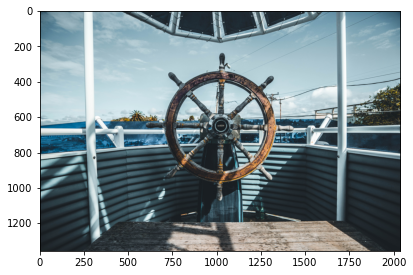

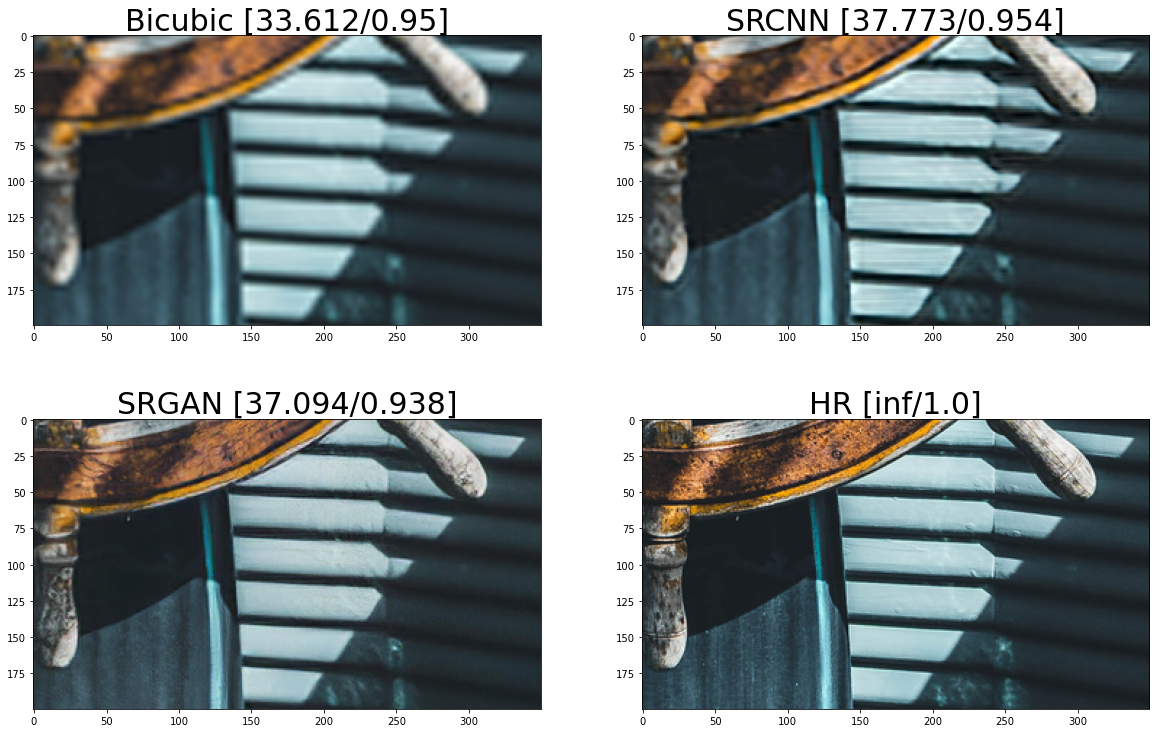

In [17]:
for i, (lr, hr) in enumerate(valid):
    if i == 11: break

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
crop_images = [crop(i, left_top, 150, 250) for i in images]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]
psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]
left_top = (900, 1000)

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

점수를 보면 SRCNN이 조금더 높게 나오지만 SRGAN보다 더 흐린 것 처럼 보인다. 단순히 MSE로 목표를 삼았기에 생기는 차이로 보인다.

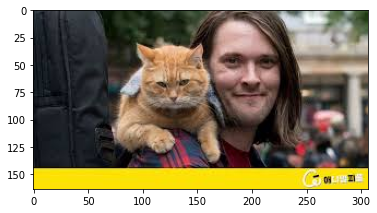

In [27]:
# 따로 다운 받은 저해상도 이미지
img = os.getenv('HOME')+'/aiffel/super_resolution/cat.jpeg'
img = cv2.imread(img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

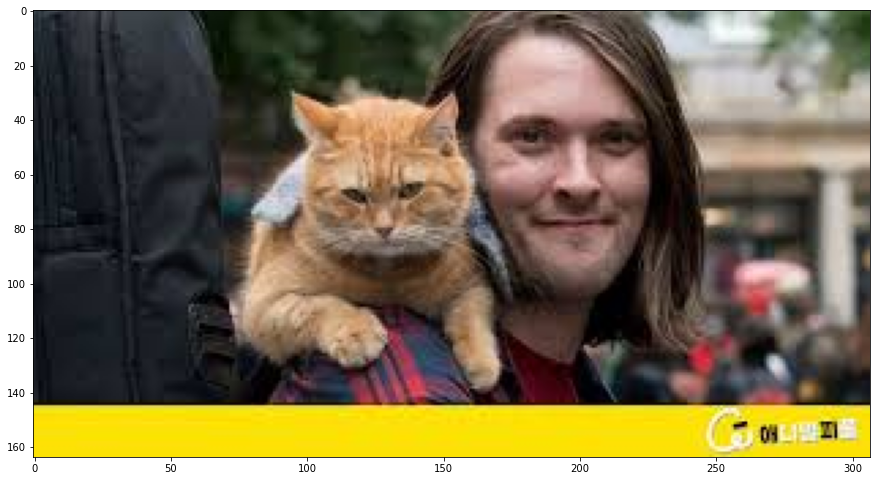

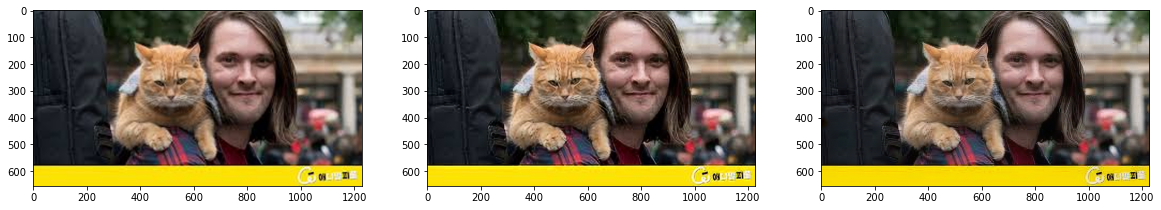

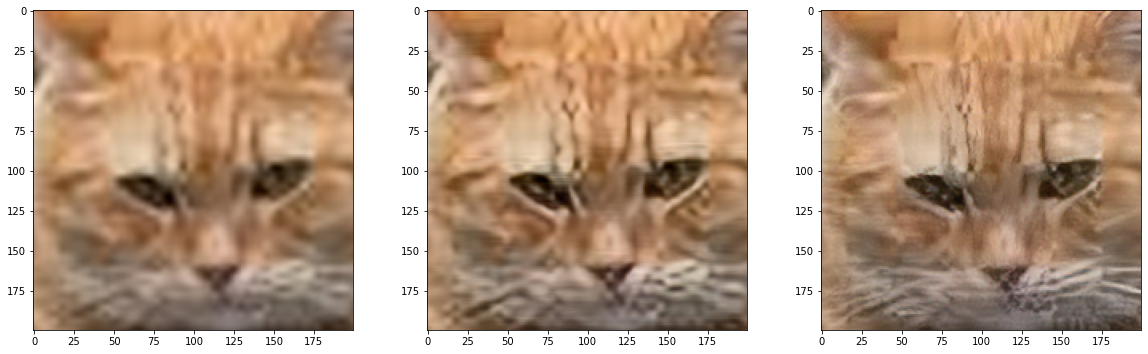

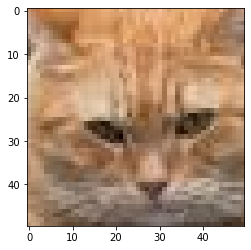

In [71]:

lr_img = img
bicubic_img = cv2.resize(
    lr_img, 
    None,
    fx= 4,
    fy = 4, 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(15,15))
plt.imshow(img)
srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)
left_top = (160, 400)
images = [bicubic_img, srcnn_img, srgan_img]
crop_images = [crop(i, left_top, 200, 200) for i in images]
titles = ["Bicubic", "SRCNN", "SRGAN"]
psnr = [round(peak_signal_noise_ratio(images[-1], i), 3) for i in images]
ssim = [round(structural_similarity(images[-1], i, multichannel=True), 3) for i in images]
psnrc = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssimc = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(20,20))
for i, pind in enumerate([331, 332, 333]):
    plt.subplot(pind)
    plt.imshow(images[i])
    # plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)
plt.show()
plt.figure(figsize=(20,20))
for i, pind in enumerate([331, 332, 333]):
    plt.subplot(pind)
    plt.imshow(crop_images[i])
    # plt.title(titles[i] + f" [{psnrc[i]}/{ssimc[i]}]", fontsize=30)
plt.show()
a = crop(lr_img,(40,100),50,50)
plt.imshow(a)

가져온 사진에서 

In [51]:
for i, pind in enumerate([321, 322, 323, 324]):
    print(i,pind)

print(images[0].shape)
print(images[1].shape)
print(images[2].shape)
# crop_images[3].shape


0 321
1 322
2 323
3 324
(328, 614, 3)
(328, 614, 3)
(656, 1228, 3)


In [30]:
a = os.getenv('HOME')+'/aiffel/super_resolution/fire_lr.gif'
gif = cv2.VideoCapture(a)

isTrue = True
frames = []
bi_frames = []
sr_frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        bi_frame = cv2.resize(frame, None,fx =4,fy= 4,interpolation=cv2.INTER_CUBIC)
        sr_frame = apply_srgan(frame)
        frames.append(frame)
        bi_frames.append(bi_frame)
        sr_frames.append(sr_frame)
print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


In [31]:
import imageio
imageio.mimsave('sr.gif',sr_frames)
imageio.mimsave('bi.gif',bi_frames)

In [39]:
imageio.mimsave('base.gif',frames)

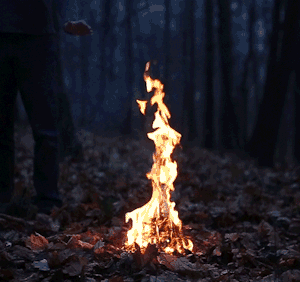

In [40]:
from IPython.display import Image
a = os.getenv('HOME')+'/workplace/base.gif' 
b = os.getenv('HOME')+'/workplace/sr.gif'
c = os.getenv('HOME')+'/workplace/bi.gif'




<img src="sr.gif" width="500" height="500">

<img src="base.gif" width="500" height="500">


<img src="bi.gif" width="500" height="500">

<img src="base.gif" width="500" height="500">